In [445]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from zipfile import ZipFile
import os

import seaborn as sns
sns.set_context(context='notebook', font_scale=2)
sns.set_style("darkgrid", {"axes.facecolor": ".9",
                           'xtick.bottom': True,
                           'xtick.top': False,
                           'ytick.left': True,
                           'ytick.right': False, })
from scipy import stats

from sklearn import cluster, neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
# %matplotlib inline
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# # Allows for multiple output values


Here we open the zip file with ZipFile and extract the the only name from the string list. We read the csv file using pandas CSV reader 


In [2]:
zip_file_name = 'gpx-hike-tracks.zip'
    # We first read the zip file using a zipfile.ZipFile object.
with ZipFile(zip_file_name) as temp_zip:
    csv_file_name = temp_zip.namelist()[0]
    with temp_zip.open(csv_file_name) as temp_csv:
        hike_df = pd.read_csv(temp_csv)
            

Here we clean up the string values under the difficulty column and add a simplified version without the + and - designation

In [3]:
fixed_label_list = []
simplified_label = []
for string in hike_df['difficulty']:  # cleans up the notation
    name_array = string.split(' ', 1)
    code = f'({name_array[0]}): '
    label = name_array[1].split('- ', 1)[1]
    fixed_label_list.append(code + label)

    simplified_label.append(string[0:2] + ': ' + label)  # removes all + or - notation (simple)
hike_df['difficulty'] = pd.Series(fixed_label_list)
hike_df['difficulty_simple'] = pd.Series(simplified_label)  # adds simple column to data frame

hike_difficulty_list = sorted(set(simplified_label), key=lambda value: int(value[1])) 
# sorts from T1 too T6 using the 1st index from the string

Metric to Imperial Units and fix time units 

In [4]:
try: 
    
    hike_df['length_3d'] /= 1609.344   # convert length_3d from meters to miles
    hike_df.rename(columns={'length_3d':'3D_length_miles'}, inplace=True)

    hike_df['length_2d'] /= 1609.344   # convert length_3d from meters to miles
    hike_df.rename(columns={'length_2d':'2D_length_miles'}, inplace=True)


    hike_df['max_elevation'] *=  3.281 # convert meters to feet
    hike_df.rename(columns ={'max_elevation' : 'max_elevation_feet'}, inplace=True)

    hike_df['min_elevation'] *= 3.281 # convert meters to feet
    hike_df.rename(columns = {'min_elevation' : 'min_elevation_feet'}, inplace=True)
    
    hike_df['max_speed'] *=  (3600 / 1609.34)  # m/s now to miles/hr
    hike_df.rename(columns = {'max_speed' : 'max_speed_mph'}, inplace=True)
    
    hike_df['moving_time'] /= 3600  # seconds to hours
    hike_df.rename(columns = {'moving_time' : 'moving_time_hr'}, inplace=True)
    
    hike_df['uphill'] *=  3.281  # convert uphill from meters to feet
    hike_df.rename(columns = {'uphill': 'uphill_feet'}, inplace=True)
    
    hike_df['downhill'] *=  3.281   # convert downhill from meters to feet
    hike_df.rename(columns = {'downhill' : 'downhill_feet'}, inplace=True)

except KeyError:
    pass


Analysis as to the maximum speed of hikers. 0 MPH,
0 < max_speed <= 1

1 < max_speed <= 2

2 < max_speed <= 3 

etc....
max_speed > n

In [5]:
max_speed_mph = hike_df.loc[:, 'max_speed_mph']
total_size = max_speed_mph.shape[0]


no_speed_size = (max_speed_mph[max_speed_mph == 0 ]).shape[0]

mph_array = list(range(0,8))
# print(mph_array)

mph_dict = {}

for i, speed in enumerate(mph_array):
    if speed == 0:
        mph_dict[speed] = (max_speed_mph[max_speed_mph == speed ]).shape[0]
        
    elif  0 < speed <= (max(mph_array) - 1):
        mph_dict[speed] = (max_speed_mph[(mph_array[i-1] < max_speed_mph) & (max_speed_mph <= speed)]).shape[0]
        
    elif speed >= max(mph_array):
        mph_dict[speed] = (max_speed_mph[max_speed_mph >= speed ]).shape[0]

# print('MPH_BINNING:',mph_dict)


# Bar-plot showing Max MPH of Hikers

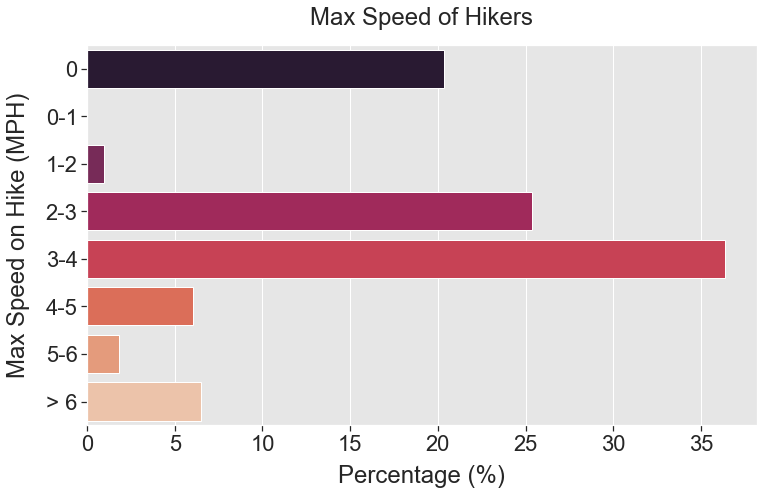

In [276]:
mph_strings = ['0', '0-1', '1-2', '2-3', '3-4', '4-5', '5-6', ' > 6']
mph_percent = np.array(list(mph_dict.values())) / total_size * 100
# mph_percent = (mph_dict.values / total_size) * 100

fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
ax = sns.barplot(mph_percent,mph_strings,palette="rocket")
plt.title("Max Speed of Hikers", pad=20);
plt.xlabel('Percentage (%)', labelpad=10);
plt.ylabel('Max Speed on Hike (MPH)',labelpad=10);
plt.savefig('max_speed_hikers.pdf', bbox_inches="tight")
plt.show()

# Remove data with max speed > 6 MPH
hike_df = hike_df[hike_df['max_speed_mph'] < 6]


Hikers with a max speed over 6 MPH makes their data suspicious while hikers with a max speed of 0 must be due to either not being reported or not calculated. 

Data with max speed > 6 MPH is removed from dataframe as it only encomposes less than 10% of the entire data and is unrealistic.

# Hiking frequency Plot 
Hiking Length of 0 Miles makes no sense, Data must be cleaned again

In [23]:
# Remove hikes with 2D length of 0 miles
hike_df = hike_df[hike_df['2D_length_miles'] > 0]

## Find the length of hikes that encompasses > 99 %

In [24]:
x = hike_df['2D_length_miles']

# Manual Quantile
for i in range(x.shape[0]):
    
    subset = (x[x < i+1]).shape[0]
    percent_of_data = subset / x.shape[0]
    if  percent_of_data < .99:
        pass
    else:
        length_cutoff = i+1
        break
        
# Fast Quantile 
length_cutoff_fast = np.ceil(x.quantile(q=0.99))
        
print(f'99% of the hikes are less than {length_cutoff} miles long')

99% of the hikes are less than 26 miles long


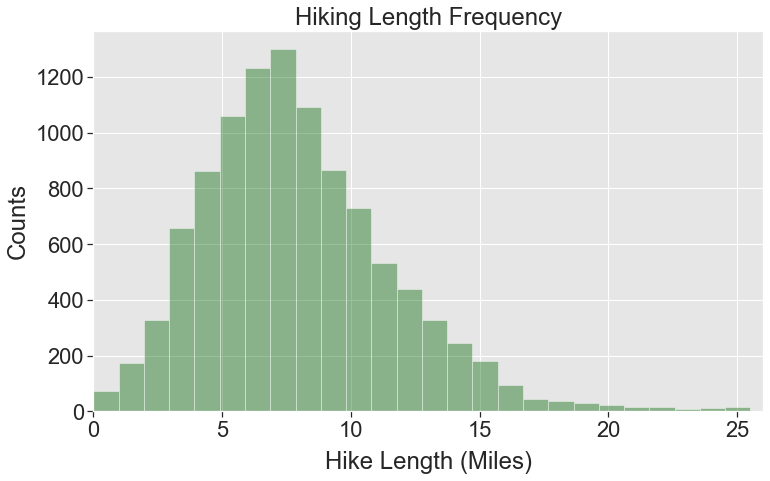

In [277]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))


ax = sns.distplot(x[x < length_cutoff], bins=length_cutoff, kde=False,  color="darkgreen")
ax.set_xlim((0, length_cutoff))
ax.set_xlabel('Hike Length (Miles)', labelpad=10)
ax.set_ylabel('Counts', labelpad=5)
ax.set_title('Hiking Length Frequency')
plt.savefig('hike_length_density.pdf', bbox_inches='tight')
plt.show()

C:\Users\adamc\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


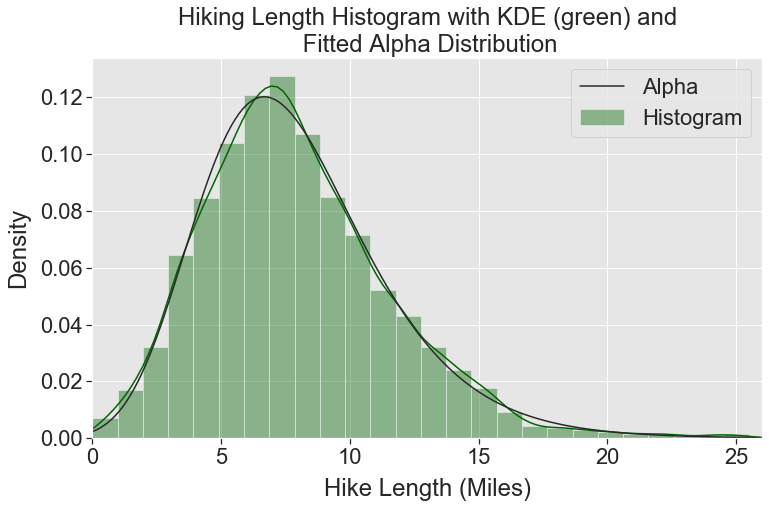

In [278]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
ax = sns.distplot(x[x < length_cutoff], bins=26, kde=True, color="darkgreen", fit=stats.alpha)
ax.set_xlim((0, length_cutoff))
ax.set_xlabel('Hike Length (Miles)', labelpad=10)
ax.set_ylabel('Density', labelpad=10)
ax.set_title('Hiking Length Histogram with KDE (green) and\n Fitted Alpha Distribution')
plt.savefig('hike_length_density.pdf', bbox_inches='tight')
plt.legend(['Alpha','Histogram'])
plt.show()

### Remove hikes longer than 26 miles

In [59]:
hike_df = hike_df[hike_df['2D_length_miles'] <= 26]

### Let's Look at Active Hiking Time

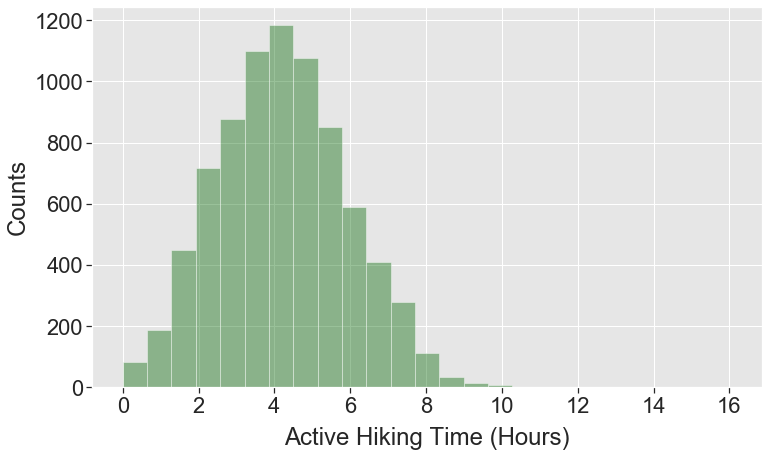

In [279]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
# hike_df[hike_df['moving_time_hr'] > 0]['moving_time_hr'].hist(bins=20)
sns.distplot(hike_df['moving_time_hr'],bins=25, kde=False, color="darkgreen")
plt.xlabel("Active Hiking Time (Hours)", labelpad=10);
plt.ylabel('Counts');

### Remove Active Hiking times of 0 hours

In [225]:
hike_df = hike_df[hike_df['moving_time_hr'] > 0]

Data points where Active Hiking time = 0 hours: 0
Maximum Active Hiking time = 16.06 hours


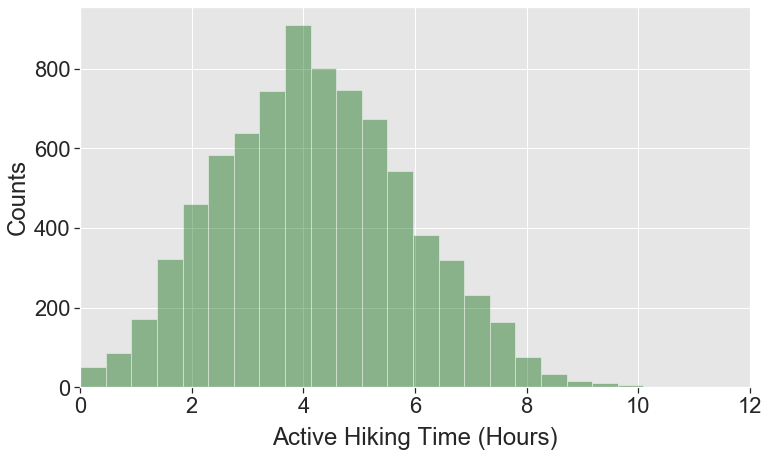

In [281]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
# hike_df[hike_df['moving_time_hr'] > 0]['moving_time_hr'].hist(bins=20)
sns.distplot(hike_df['moving_time_hr'],bins=35, kde=False, color="darkgreen")
plt.xlabel("Active Hiking Time (Hours)", labelpad=10);
plt.ylabel('Counts');
plt.xlim([0, 12])

print('Data points where Active Hiking time = 0 hours:',hike_df[hike_df['moving_time_hr'] == 0].shape[0])
print('Maximum Active Hiking time =', round(hike_df['moving_time_hr'].max(),2), 'hours')

### Remove ascent that is less than 0 feet and ascent for quantiles greater than 99% (false data)! 

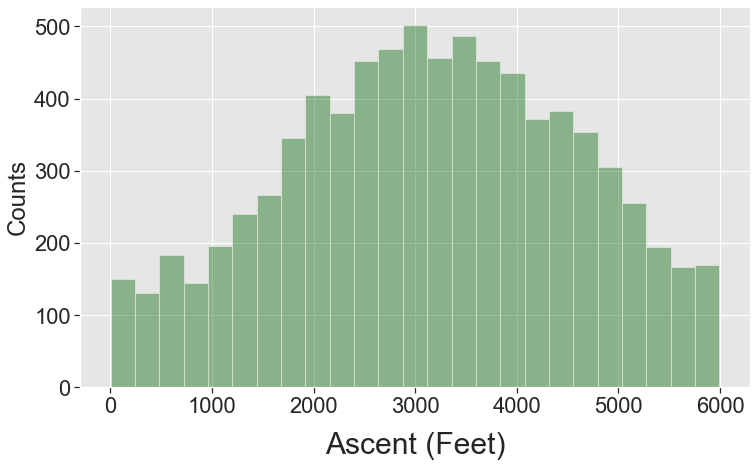

In [282]:
hike_df = hike_df[hike_df['uphill_feet'] > 0]
ascent_threshold = hike_df['uphill_feet'].quantile(q=.99)
hike_df = hike_df[hike_df['uphill_feet'] <= ascent_threshold]
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))

# hike_df[hike_df['moving_time_hr'] > 0]['moving_time_hr'].hist(bins=20)
sns.distplot(hike_df['uphill_feet'],bins=25, kde=False, color="darkgreen")
plt.xlabel('Ascent (Feet)', labelpad=15, fontsize=30);
plt.ylabel('Counts');

In [407]:
minimial_df = hike_df[['2D_length_miles', 'moving_time_hr', 'uphill_feet', 'difficulty_simple']].sort_values(['difficulty_simple'])

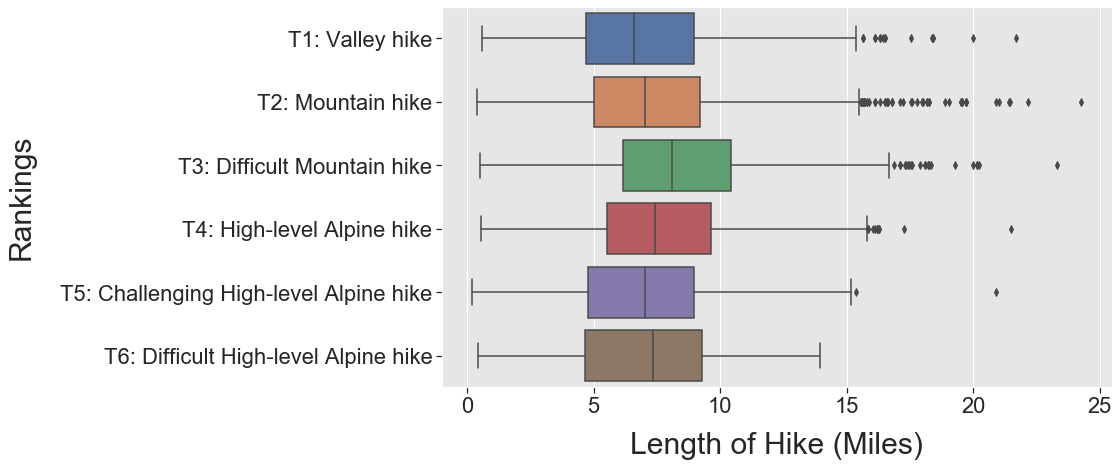

In [283]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
sns.boxplot(x='2D_length_miles', y='difficulty_simple', data=minimial_df)
plt.xlabel('Length of Hike (Miles)', labelpad=15, fontsize=30);
plt.ylabel('Rankings', labelpad=25, fontsize=30);

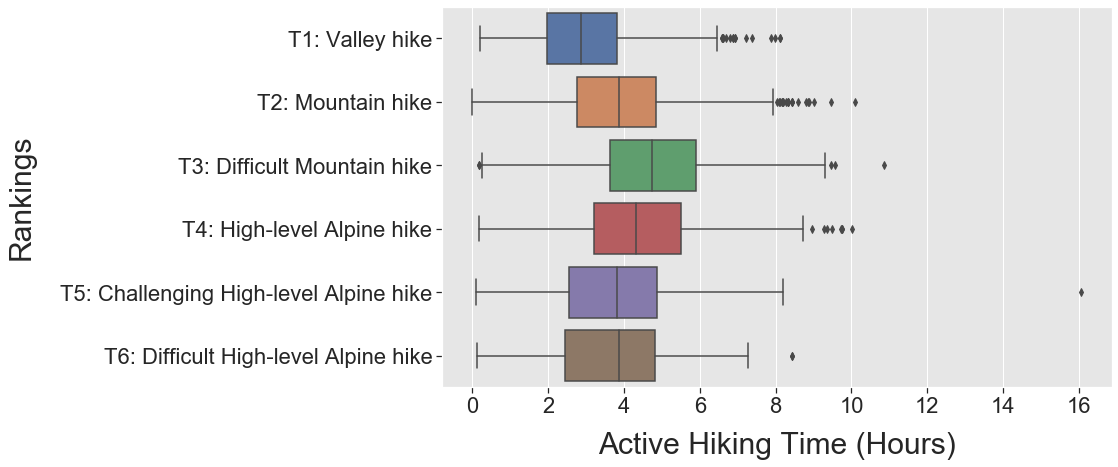

In [284]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
sns.boxplot(x='moving_time_hr', y='difficulty_simple', data=minimial_df)
plt.xlabel('Active Hiking Time (Hours)', labelpad=15, fontsize=30);
plt.ylabel('Rankings', labelpad=25, fontsize=30);

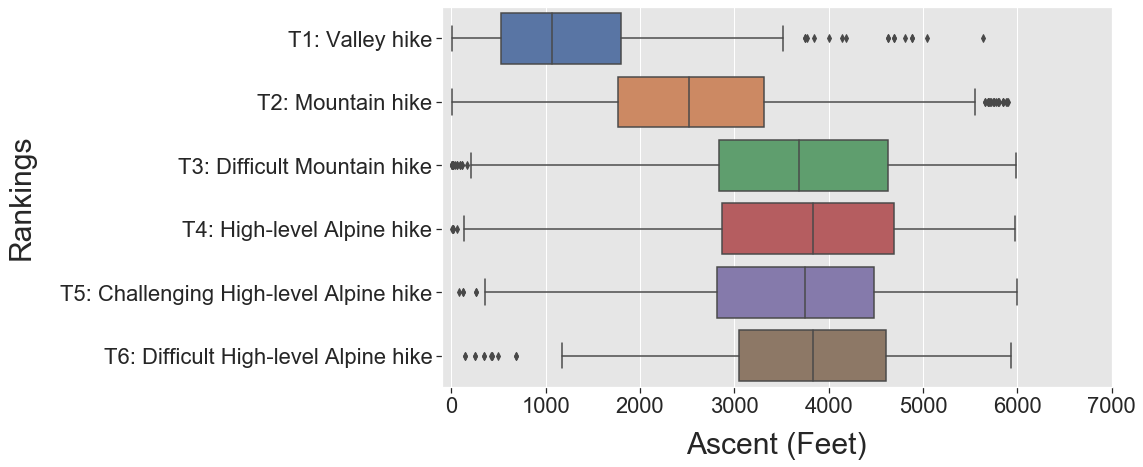

In [420]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
sns.boxplot(x='uphill_feet', y='difficulty_simple', data=minimial_df)
plt.xlabel('Ascent (Feet)', labelpad=15, fontsize=30);
plt.ylabel('Rankings', labelpad=25, fontsize=30);
plt.xlim([-100, 7000]);

In [434]:
# minimial_df[(minimial_df.difficulty_simple == 'T1: Valley hike') & (minimial_df.uphill_feet > 4000)]
# 
minimial_df[(minimial_df.difficulty_simple == 'T1: Valley hike') & (minimial_df.uphill_feet > 4000)]['2D_length_miles'] / minimial_df[(minimial_df.difficulty_simple == 'T1: Valley hike') & (minimial_df.uphill_feet > 4000)]['moving_time_hr']

2367     1.984266
7583     1.785418
1208     1.939156
9777     2.968733
6375     1.568380
6088     2.354404
6093     1.592684
6229     1.984266
3668     1.785418
11082    5.144229
2224     2.354404
6440     1.755933
dtype: float64

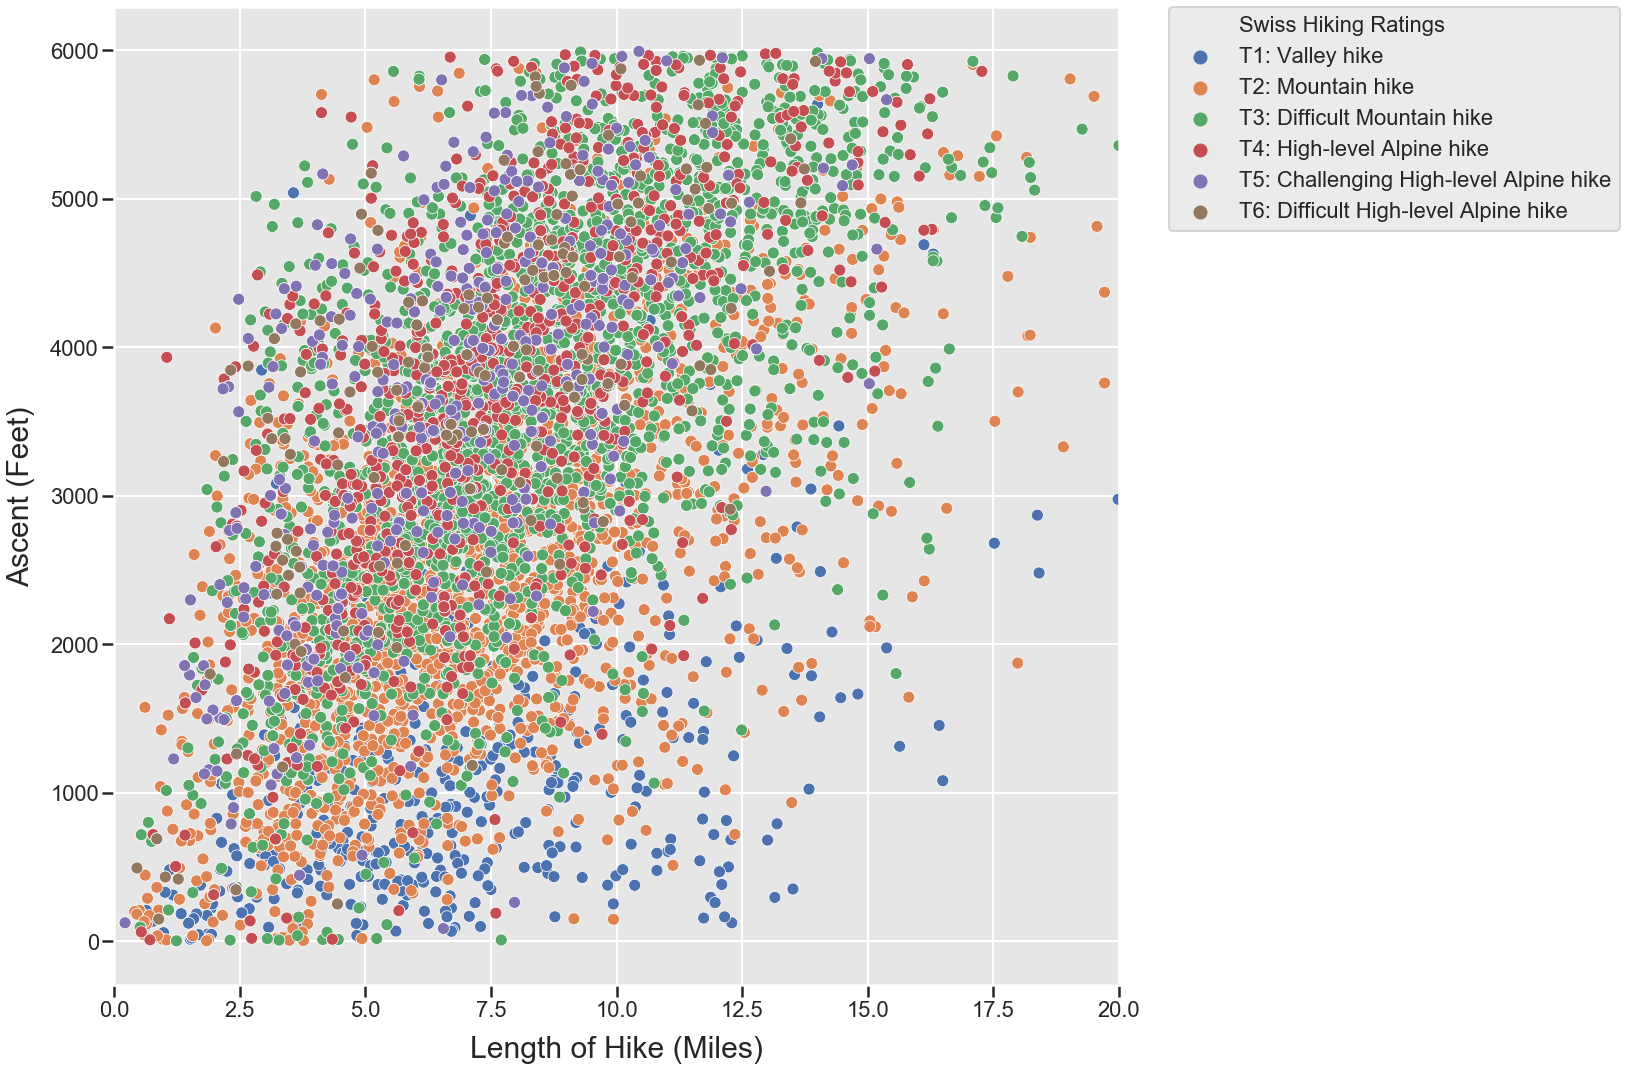

In [419]:
with sns.plotting_context('poster'):
    fig, ax = plt.subplots(ncols=1, figsize=(18, 18))
    sns.scatterplot(x='2D_length_miles', y='uphill_feet', hue='difficulty_simple',  data=minimial_df, ax=ax,)
    plt.ylabel('Ascent (Feet)', labelpad=15, fontsize=30);
    plt.xlabel('Length of Hike (Miles)', labelpad=15, fontsize=30);
    plt.xlim([0, 20])
    handles, labels = ax.get_legend_handles_labels();  # plot legend though from newest to oldest
    labels[0] = 'Swiss Hiking Ratings'
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


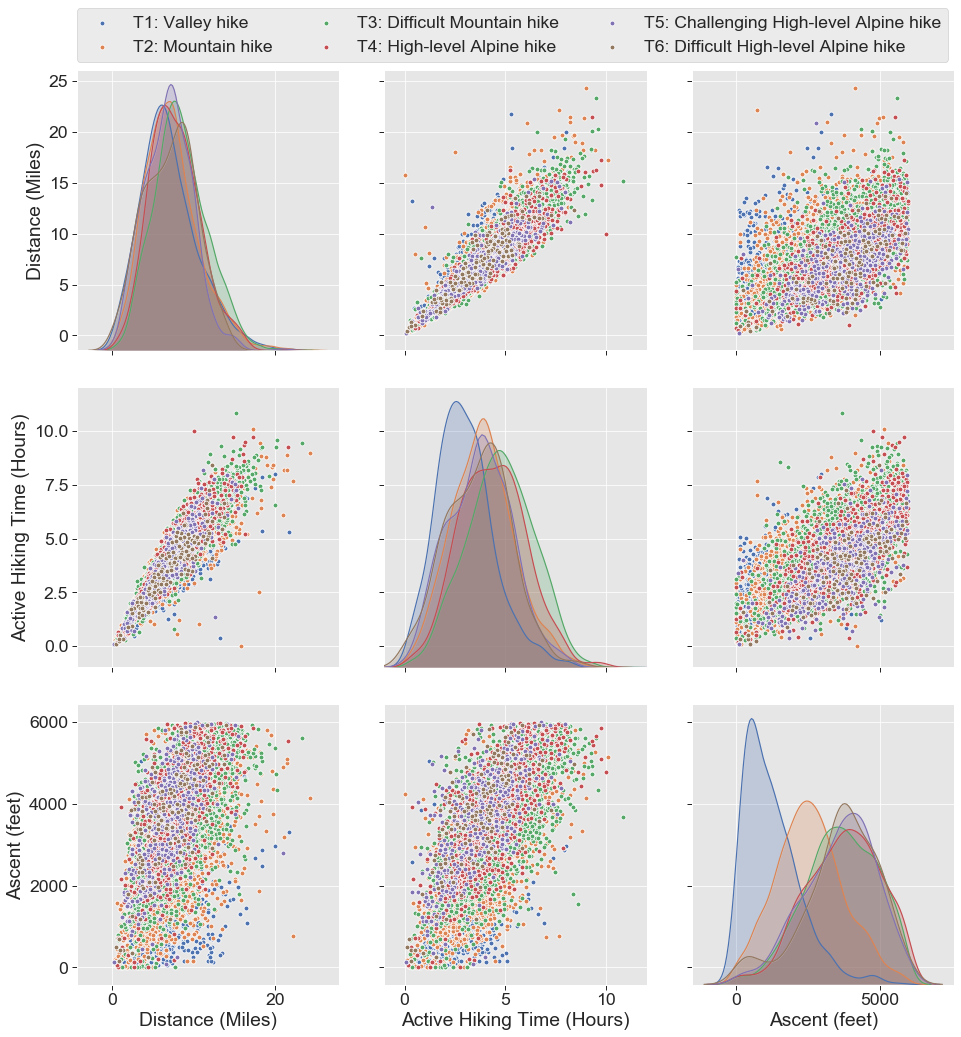

In [418]:
with sns.plotting_context('paper', font_scale=2):
    g = sns.pairplot(minimial_df , hue="difficulty_simple")
    replacements = {'2D_length_miles': 'Distance (Miles)', "moving_time_hr": 'Active Hiking Time (Hours)', "uphill_feet": 'Ascent (feet)'}
    for i in range(3):
        for j in range(3):
            xlabel = g.axes[i][j].get_xlabel()
            ylabel = g.axes[i][j].get_ylabel()
            if xlabel in replacements.keys():
                g.axes[i][j].set_xlabel(replacements[xlabel])
            if ylabel in replacements.keys():
                g.axes[i][j].set_ylabel(replacements[ylabel])
                
    for i in range(3):
        for j in range(3):
            if j==1:
                g.axes[i][j].set_xlim(-1, 12)
            if i==1:
                g.axes[i][j].set_ylim(-1, 12)
                
    g._legend.remove()

    g.fig.set_size_inches(25,15)

    g._legend.set_title("Swiss Hiking Ratings")
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc=(0.08, 0.94), borderaxespad=0, ncol=3)
    g.fig.subplots_adjust(top=0.93)

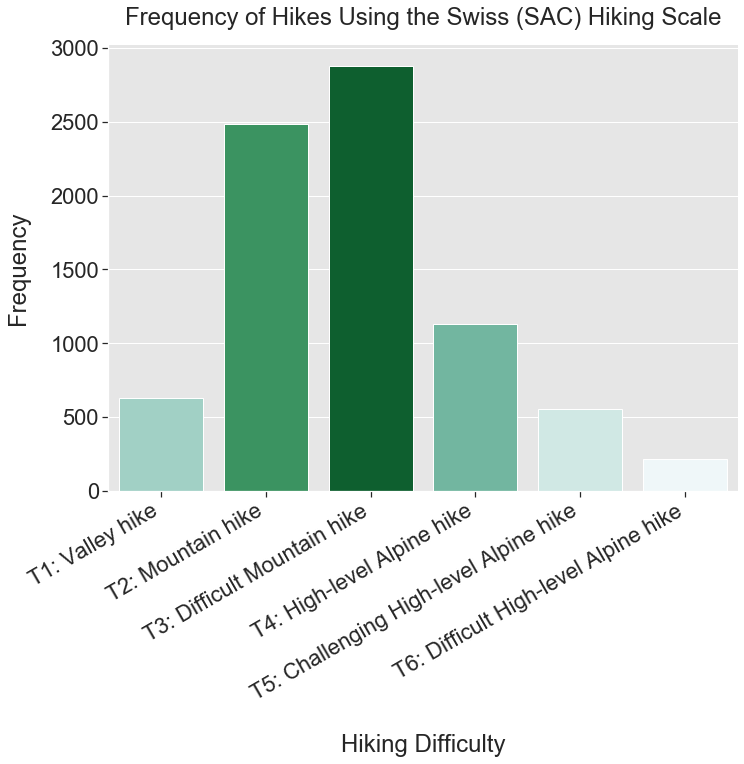

,difficulty,hiking_colors,code
T1: Valley hike,627,#99d8c9,1
T2: Mountain hike,2485,#2ca25f,2
T3: Difficult Mountain hike,2878,#006d2c,3
T4: High-level Alpine hike,1129,#66c2a4,4
T5: Challenging High-level Alpine hike,554,#ccece6,5
T6: Difficult High-level Alpine hike,219,#edf8fb,6


In [438]:
difficulty_series = hike_df['difficulty_simple'].value_counts()  # retrieves which hikes were most popular
ranked_values = pd.Series.tolist(difficulty_series)  # convert to a list

hiking_colors = ['#edf8fb',  # lightest green
                 '#ccece6',
                 '#99d8c9',
                 '#66c2a4',
                 '#2ca25f',
                 '#006d2c'  # darkest green
                 ]
hiking_colors = [x for _, x in sorted(zip(ranked_values, hiking_colors))] 
# sorts colors by ranked values, now lighted color for smallest value

color_df = pd.DataFrame(ranked_values, columns=['difficulty'], index=difficulty_series.index)
color_df['hiking_colors'] = hiking_colors
color_df['code'] = [code[1] for code in difficulty_series.index]
color_df = color_df.sort_values(by=['code'], ascending=True)

ax = sns.catplot(x='difficulty_simple', kind='count', data=hike_df, orient="v", height=8.27,
                 aspect=11.7 / 8.27, order=hike_difficulty_list, palette=color_df['hiking_colors'])
ax.fig.autofmt_xdate()
plt.xlabel('Hiking Difficulty', labelpad=30)
plt.ylabel('Frequency', labelpad=20)
plt.title("Frequency of Hikes Using the Swiss (SAC) Hiking Scale", pad=20)
plt.savefig('diff_vs_freq.pdf', bbox_inches="tight")
plt.show()

color_df  # show table

## Unsupervised Clustering

In [578]:
cluster_sizes = np.arange(2,6)
sil_scores = {}


for n in cluster_sizes:
    cls_hike = cluster.KMeans(n_clusters=n)
    cls_hike.fit(minimial_df[['uphill_feet', '2D_length_miles', 'moving_time_hr']])
    sil_score = silhouette_score(minimial_df[['uphill_feet', '2D_length_miles', 'moving_time_hr']], cls_hike.labels_)
    print(f'n={n} ->', sil_score)
    sil_scores[f'n={n}']=sil_score

n=2 -> 0.5725724468011503
n=3 -> 0.5523394851447727
n=4 -> 0.5435990825353029
n=5 -> 0.5352176237648274


Text(0.5, 0.92, 'K-Means Cluster of $n=3$\nSilhouette Score = 0.55')

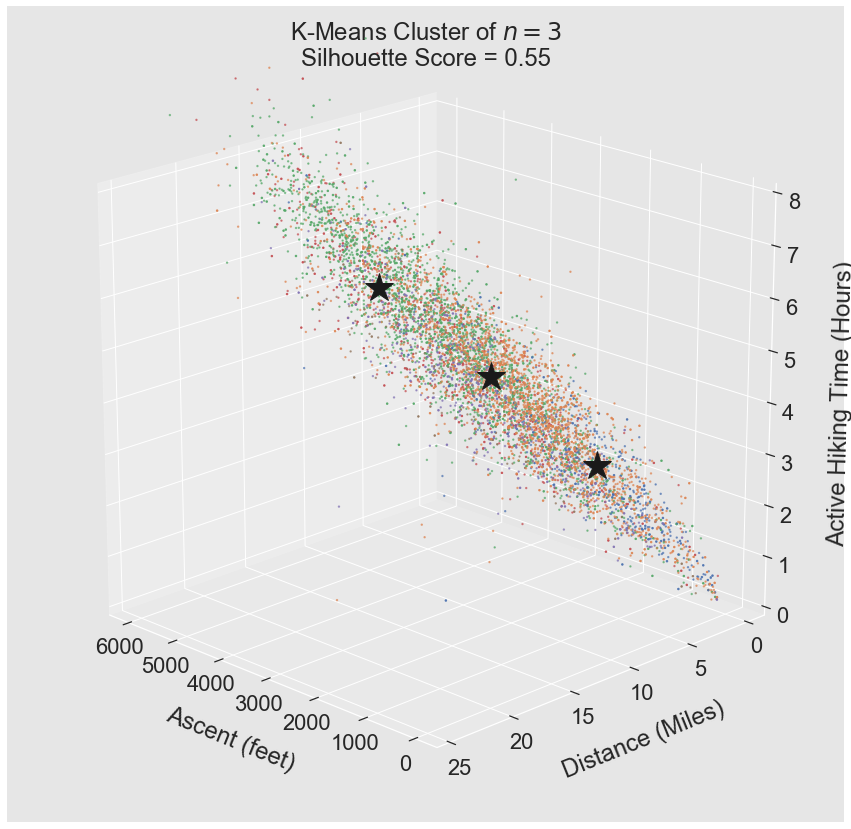

In [568]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=135)

unique_classes = minimial_df.difficulty_simple.unique()
for i in range(6):
    temp_df = minimial_df[minimial_df.difficulty_simple == unique_classes[i]]
    ax.scatter(temp_df['uphill_feet'], temp_df['2D_length_miles'], temp_df['moving_time_hr'], marker='o', s=2, alpha=0.6,zorder=-i )
fig.set_size_inches(15,15)
ax.set_xlabel('Ascent (feet)', labelpad=25);
ax.set_ylabel('Distance (Miles)', labelpad=25);
ax.set_zlabel('Active Hiking Time (Hours)', labelpad=25);
ax.set_zlim([0, 8]);
# ax.scatter(cls_hike.cluster_centers_[:,0], cls_hike.cluster_centers_[:,1], cls_hike.cluster_centers_[:,2], marker='*', s=900, alpha=1, c='k', zorder=-10000)
ax.plot(cls_hike.cluster_centers_[:,0], cls_hike.cluster_centers_[:,1], cls_hike.cluster_centers_[:,2], '*', markersize=30,
        lw=0, color='k', zorder=100)
plt.title(r'K-Means Cluster of $n=3$' + '\n' + f'Silhouette Score = {sil_score:.2f}')

# Classification Models
